# Intro
This notebook code is used to apply the Self-Organizing Map (SOM) alghoritm to the Chandra Source Catalog (CSC) version 1. This is the first attempt to apply the SOM algorithm and the following code is specifically being used to test the features of the minisom package.

In [1]:
from IPython.display import display, Image
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord
from astropy import units as u
from minisom import MiniSom
import seaborn as sns
import pandas as pd
import numpy as np
import math

from tqdm import tqdm

Loading the raw and log-normalized datasets from CSV files into pandas DataFrames.

In [2]:
raw_dataset_path = './data/cluster_csc_simbad.csv'
dataset_path = './data/cluster_csc_simbad_log_normalized.csv'

# Load the dataset
raw_df = pd.read_csv(raw_dataset_path)
df = pd.read_csv(dataset_path)

/var/folders/lr/d8nq9v9x525g290h3kqjrbgw0000gq/T/ipykernel_21503/3365918053.py:5: DtypeWarning: Columns (56,63,64,65,66,67,68,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(raw_dataset_path)


Extracting the right ascension (ra) and declination (dec) from the raw dataset and converts them into galactic coordinates.

In [3]:
# get ra and dec
ra = raw_df['ra']
dec = raw_df['dec']
# transform it to galactic coordinates
c = SkyCoord(ra, dec, frame='icrs', unit=u.deg)
l_rad = c.galactic.l.wrap_at('180d').radian
b_rad = c.galactic.b.radian

Extracting the cluster labels derived from applying the unsupervised learning technique, Gaussian Mixture Models (GMMs), to the Chandra Source Catalog (CSC).

In [4]:
GMM_cluster_labels = df['cluster']
df = df.drop(columns=['cluster'])

## Features Selection

In this notebook we try to select a portion of the initial features, more specifically:
- hard_hm
- hard_hs
- hard_ms
- bb_kt
- powlaw_gamma

In [5]:
# Drop all the columns expect the ones we want to use
# All columns: ['hard_hm', 'hard_hs', 'hard_ms', 'bb_kt', 'powlaw_gamma', 'var_prob_b', 'var_prob_h', 'var_prob_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b']

subset_of_df = df.drop(columns=['var_prob_b', 'var_prob_h', 'var_prob_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b'])
# get the number of features
features = subset_of_df.shape[1]

## Data Analysis
After pre-processing

In [6]:
subset_of_df.head()

,hard_hm,hard_hs,hard_ms,bb_kt,powlaw_gamma
0,-0.049969,-0.277327,-0.229856,0.183960,0.416995
1,0.041224,-0.278576,-0.311056,0.150790,0.410228
2,0.033729,-0.329794,-0.358526,0.163320,0.409759
3,0.154903,-0.126171,-0.276077,0.204927,0.389857
4,0.176140,0.008745,-0.168645,0.233930,0.368198


For seeing the distributions between a few variables

In [7]:
def seaborn_histplot(df, columns, labels, title, xlabel):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    for i, column in enumerate(columns):
        sns.histplot(df.loc[:, column], ax=axes[0], kde=True, stat='count', label=labels[i])
        sns.histplot(df.loc[:, column], ax=axes[1], kde=True, stat='density', label=labels[i])
    plt.suptitle(title)
    axes[0].set_title("Count distribution")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel("Count")
    axes[0].legend()
    axes[1].set_title("Density distribution")
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel("Density")
    axes[1].legend()
    plt.show()

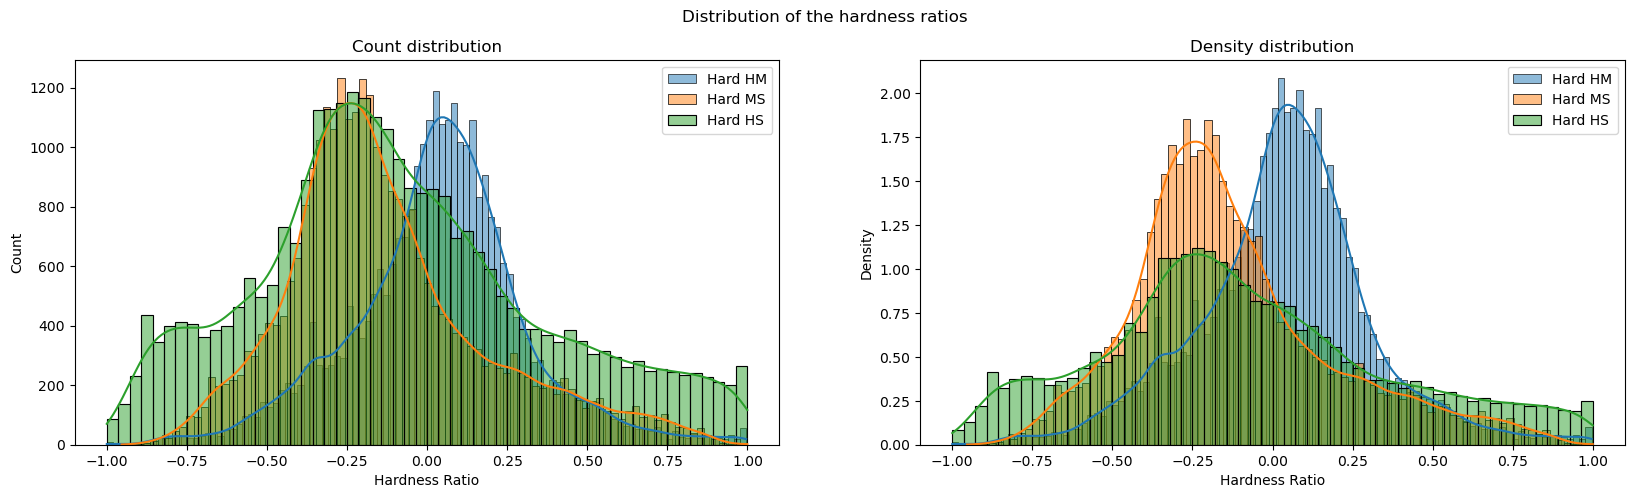

In [8]:
seaborn_histplot(subset_of_df, ['hard_hm', 'hard_ms', 'hard_hs'], ['Hard HM', 'Hard MS', 'Hard HS'], 'Distribution of the hardness ratios', 'Hardness Ratio')

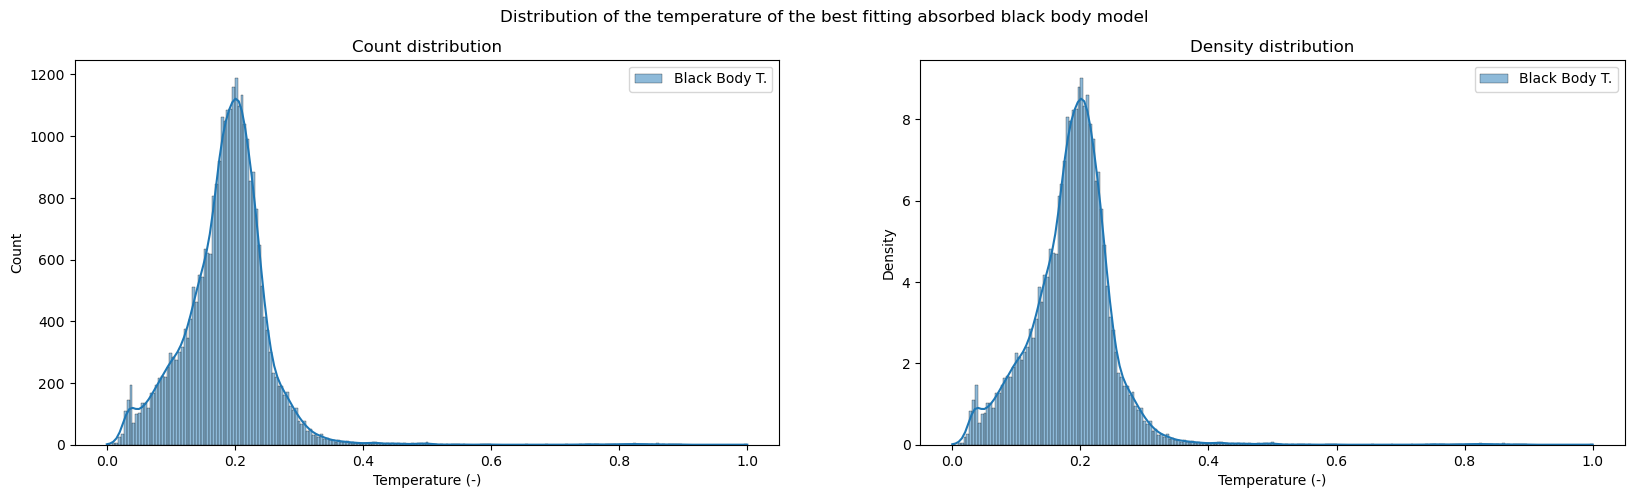

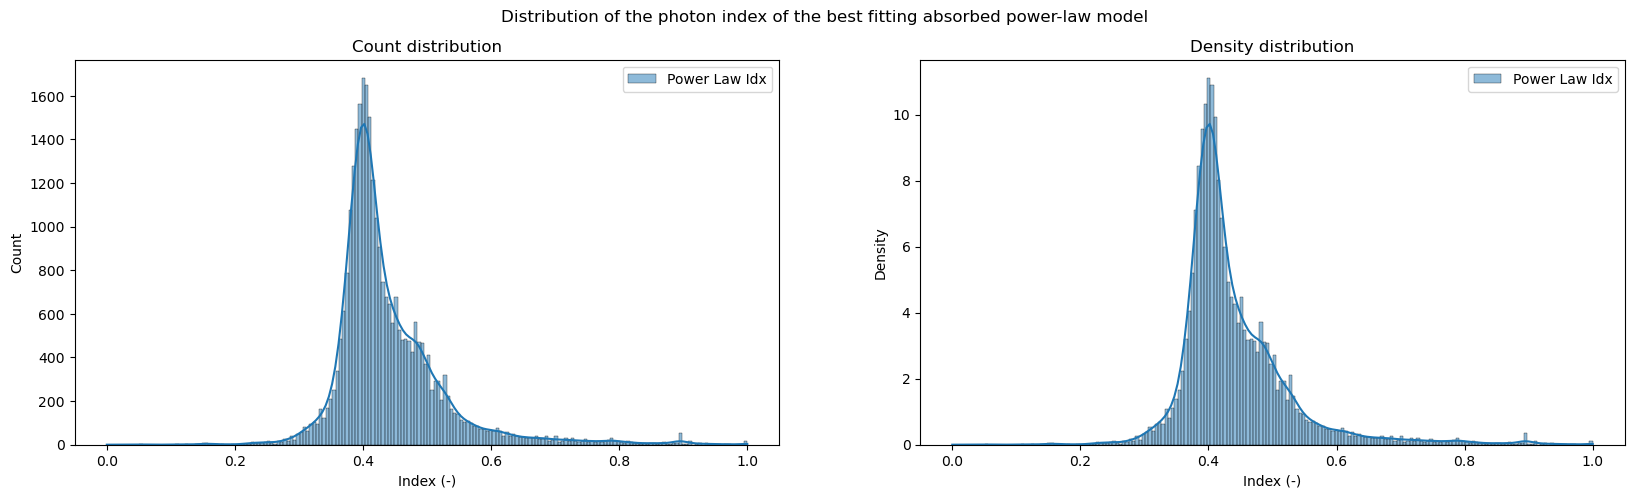

In [9]:
seaborn_histplot(subset_of_df, ['bb_kt'], ['Black Body T.'], 'Distribution of the temperature of the best fitting absorbed black body model', 'Temperature (-)')
seaborn_histplot(subset_of_df, ['powlaw_gamma'], ['Power Law Idx'], 'Distribution of the photon index of the best fitting absorbed power-law model', 'Index (-)')

## Correlation Heatmaps

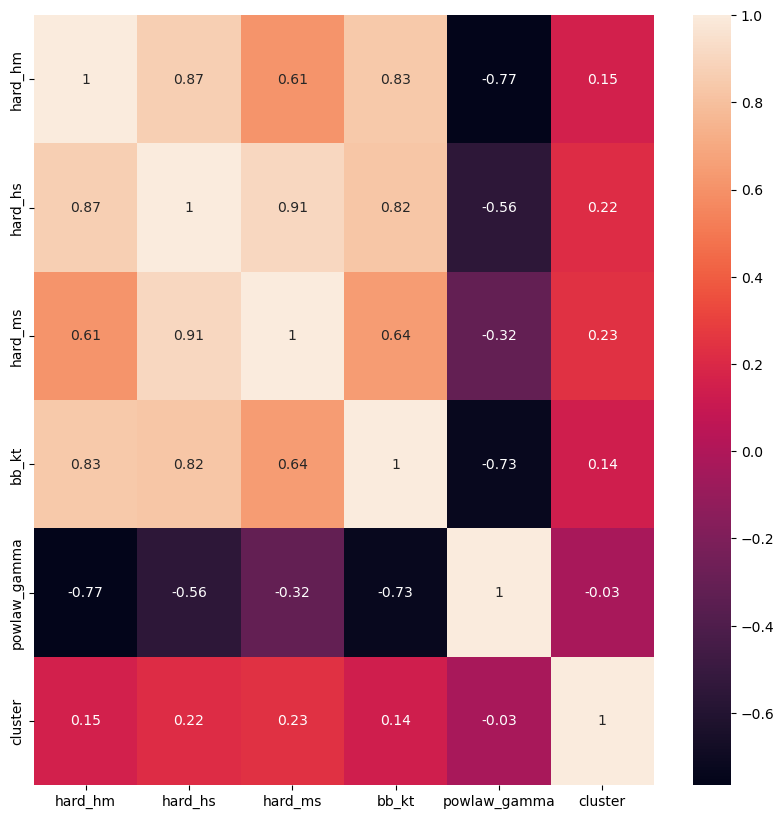

In [10]:
#data_and_target = pd.concat([df, pd.DataFrame(GMM_cluster_labels, columns=["GMM Cluster"])], axis=1)
df_and_cluster = pd.concat([subset_of_df, GMM_cluster_labels], axis=1)
Var_Corr = df_and_cluster.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

## SOM
### with random hyperparameters

Obtaining the correspoinding Numpy matrix

In [11]:
# Get the dataset as a numpy array
X = subset_of_df.to_numpy()

In the following code we are training a 2-D SOM to reduce the dimensionalty of the data. As a rule of thumb for choosing the number of dim: 5 * sqrt(n) where n is the number of samples [GAMA paper]

In [12]:
len_data = len(X)
print('Number of data points: {}'.format(len_data))
dim_number = 10 # TO CHANGE with -> int(5 * np.sqrt(len_data))
print('Number of dimensions: {}'.format(dim_number))
print('Number of features: {}'.format(features))
train_iterations = 100

Number of data points: 29655
Number of dimensions: 10
Number of features: 5


In [13]:
som = MiniSom(dim_number, dim_number, features, sigma=1.5, learning_rate=.5)
som.train(X, train_iterations, verbose=True) # trains the SOM with 100 iterations

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.16175037875314002


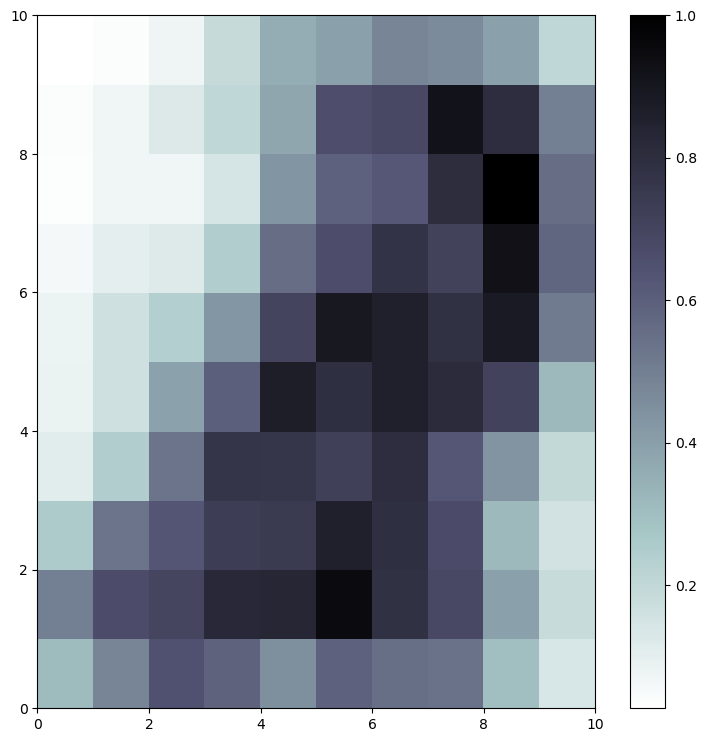

In [14]:
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the dataset
# different colors and markers for each label
markers = ['o', 's', 'D', 'v', '^', 'p']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

'''
for cnt, xx in enumerate(X):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[GMM_cluster_labels[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[GMM_cluster_labels[cnt]-1], markersize=12, markeredgewidth=2)
'''

plt.show()

## MiniSom's Hyperparameters:
- x: number of columns*
- y: number of rows
- sigma: spread of the neighborhood function (needs to be adequate to the dimensions of the map. sigma < x/2.0 and sigma < y/2.0)
- learning rate
- iterations  

## Error to minimize:

The Quantization Error** is computed by determining the average distance of the sample vectors to the cluster centroids by which they are represented.

*The QE, declines as the map becomes larger. Thus, the QE can not be used to compare maps of different sizes. Polzlbauer (2004)  
*The number of columns and rows should be 5 * sqrt(len(N)) Vesanto (2005)

In [15]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import time

In [16]:
markers = ['o', 's', 'D', 'v', '^', 'p']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

In [17]:
def train_som(x, Y, input_len, sigma, learning_rate, train_iterations):
    # initialization
    som = MiniSom(x=x, y=Y, input_len=input_len, sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X)
    # training
    start_time = time.time()
    som.train_random(X, train_iterations) # training with 100 iterations
    elapsed_time = time.time() - start_time
    print(elapsed_time, "seconds")
    return som

# Def plot and projection

In [18]:
def project_feature(som, X, feature):
    '''
    Returns a 2D map of lists containing the values of the external feature for each neuron of the SOM
    '''
    map = [[[None] for _ in range(som._weights.shape[1])] for _ in range(som._weights.shape[0])]
    for cnt, xx in enumerate(X):
        w = som.winner(xx)
        if map[w[0]][w[1]][0] == None:
            map[w[0]][w[1]] = [feature[cnt]]
        else:
            map[w[0]][w[1]].append(feature[cnt])
    return map

def plot_feature(map, ax, fig=None, scaling='sum'):
    '''
    Plot the map (which is a list) of the external feature, different scaling methods are available:
    - sum
    - mean
    - max
    - min
    - median
    and category will plot the most common element in the list
    '''
    np_map = np.empty((len(map), len(map[0])))
    #plt.figure(figsize=(10, 10))
    #bone
    # Convert map to a list of lists (2D) by summing or averaging over the third dimension
    if scaling == 'sum':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                try:
                    np_map[idx_outer][idx_inner] = sum(sublist)
                except TypeError:
                    np_map[idx_outer][idx_inner] = 0
    elif scaling == 'mean':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                try:
                    np_map[idx_outer][idx_inner] = sum(sublist)/len(sublist)
                except TypeError:
                    np_map[idx_outer][idx_inner] = 0
    elif scaling == 'max':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                try:
                    np_map[idx_outer][idx_inner] = max(sublist)
                except TypeError:
                    np_map[idx_outer][idx_inner] = 0
    elif scaling == 'min':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                try:
                    np_map[idx_outer][idx_inner] = min(sublist)
                except TypeError:
                    np_map[idx_outer][idx_inner] = 0
    elif scaling == 'median':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                try:
                    np_map[idx_outer][idx_inner] = np.median(sublist)
                except TypeError:
                    np_map[idx_outer][idx_inner] = 0
    elif scaling == 'category':
        for idx_outer, sublist_outer in enumerate(map):
            for idx_inner, sublist in enumerate(sublist_outer):
                # the most common element in the list is the category
                try:
                    np_map[idx_outer][idx_inner] = max(set(sublist), key=sublist.count)
                except TypeError:
                    np_map[idx_outer][idx_inner] = None
        for idx_outer, sublist_outer in enumerate(np_map):
            for idx_inner, sublist in enumerate(sublist_outer):
                if not math.isnan(sublist):
                    ax.plot(idx_outer+.5, idx_inner+.5, markers[int(sublist)], markerfacecolor='None',
                            markeredgecolor=colors[int(sublist)], markersize=12, markeredgewidth=2, label=str(int(sublist)))
    
        handles, labels = plt.gca().get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)
        # order new labels
        newLabels = [x for x, _ in sorted(zip(newLabels, newHandles))]
        newHandles = sorted(newHandles, key=lambda x: x.get_label())
        ax.legend(newHandles, newLabels)
        ax.axis([0, len(np_map), 0, len(np_map[0])])
        return ax
    else:
        raise ValueError('Scaling method not recognized')
    
    dmap = ax.pcolor(np_map.T, cmap='bone_r')
    if fig != None:
        fig.colorbar(dmap)
    ax.axis([0, len(np_map), 0, len(np_map[0])])
    return ax

    
def plot_distance_map(som):
    '''
    Plot the distance map of the SOM
    '''
    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    plt.colorbar()
    plt.show()

def plot_som(som, ax, data=None, features=None):
    '''
    Plot the SOM with all the data points or the categories of the data points (for cleaner visualization of categories look at the plot_feature function)
    '''
    if data == "category":
        for cnt, xx in enumerate(X):
            w = som. winner(xx)
            # palce a marker on the winning position for the sample x
            ax.plot(w[0]+.5, w[1]+.5, markers[GMM_cluster_labels[cnt]], markerfacecolor='None',
                markeredgecolor=colors[GMM_cluster_labels[cnt]], markersize=12, markeredgewidth=2)
            
    if data == "sample":
        label_names = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}

        w_x, w_y = zip(*[som.winner(d) for d in X])
        w_x = np.array(w_x)
        w_y = np.array(w_y)

        for c in np.unique(GMM_cluster_labels):
            idx_target = GMM_cluster_labels==c
            ax.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                        w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                        s=5, c=colors[c], label=label_names[c])
        ax.legend(loc='upper right')
        ax.grid()
    
    
    ax.axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
    return ax

## Tuning Sigma and LR by Reducing Quantization Error with hyperopt.fmin
1. Given observed values of the loss function, f(x), update the posterior expectation of fusing the Gaussian Process model.
2. Find xnew that maximises the Expected Improvement (El): xnew=argmaxEl(x).
3. Compute the value of f for the point new.  


Thomas Huijskens' Github: (https://github.com/thuijskens/bayesian-optimization)

In [19]:
space={
    'sig': hp.uniform('sig', 0.001, 5), 
    'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }

def som_fn_qe(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=dim_number, y=dim_number, input_len=features, sigma=sig, learning_rate=learning_rate).quantization_error(X)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

def som_fn_te(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=dim_number, y=dim_number, input_len=features, sigma=sig, learning_rate=learning_rate).topographic_error(X)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

trials_QE = Trials()
best_QE = fmin(fn=som_fn_qe, space=space, algo=tpe.suggest, max_evals=1000, trials=trials_QE)
print('best QE: {}'.format (best_QE))

trials_TE = Trials()
best_TE = fmin(fn=som_fn_te, space=space, algo=tpe.suggest, max_evals=1000, trials=trials_TE)
print('best: {}'.format (best_TE))

for i, trial in enumerate(trials_QE.trials[:2]):
    print("QE:")
    print(i, trial)

for i, trial in enumerate(trials_TE.trials[:2]):
    print("TE:")
    print(i, trial)

0.5340168278790479                                      
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

0.4988252809418634                                      
0.4729321174122646                                                                
0.5396790560310492                                                                
0.5641175868258989                                                                
0.4782236015140958                                                                
0.5160215270482712                                                                
0.5216718707992342                                                                
0.4623289724978454                                                                
0.5490895906061808                                                                
0.5662673497601755                                                                
0.5226007803840214                                                                 
0.4629389993517276                                                                 
0.5448391826564246          

In [20]:
print ("x: {},\ny: {},\ninput_len: {})".format (dim_number, dim_number, features))

sigma_QE = best_QE['sig']
learning_rate_QE = best_QE['learning_rate']
print("nsigma QE: {},\nlearning_rate QE: {}".format(sigma_QE, learning_rate_QE))

sigma_TE = best_TE['sig']
learning_rate_TE = best_TE['learning_rate']
print("nsigma TE: {},\nlearning_rate TE: {}".format(sigma_TE, learning_rate_TE))

x: 10,
y: 10,
input_len: 5)
nsigma QE: 1.693036864721327,
learning_rate QE: 0.9572856627450016
nsigma TE: 2.927990995937896,
learning_rate TE: 3.1688066091230755


## Number of iterations

Tuning the number of iterations needed by saving the quantization and the topographic error for each step using the sigma and learning rate optimazed for QE and TE

In [21]:
def get_iterations_index(dim_number, features, sigma, learning_rate, max_iter=1000):

    som = MiniSom(dim_number, dim_number, features, sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian')

    q_error = []
    t_error = []

    for i in tqdm(range(max_iter)):
        rand_i = np.random.randint(len(X))
        som.update(X[rand_i], som.winner(X[rand_i]), i, max_iter)
        q_error.append(som.quantization_error(X))
        t_error.append(som.topographic_error(X))
    
    return q_error, t_error

In [22]:
q_error_QE, t_error_QE = get_iterations_index(dim_number, features, sigma_QE, learning_rate_QE)
q_error_TE, t_error_TE = get_iterations_index(dim_number, features, sigma_TE, learning_rate_TE)

100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s]


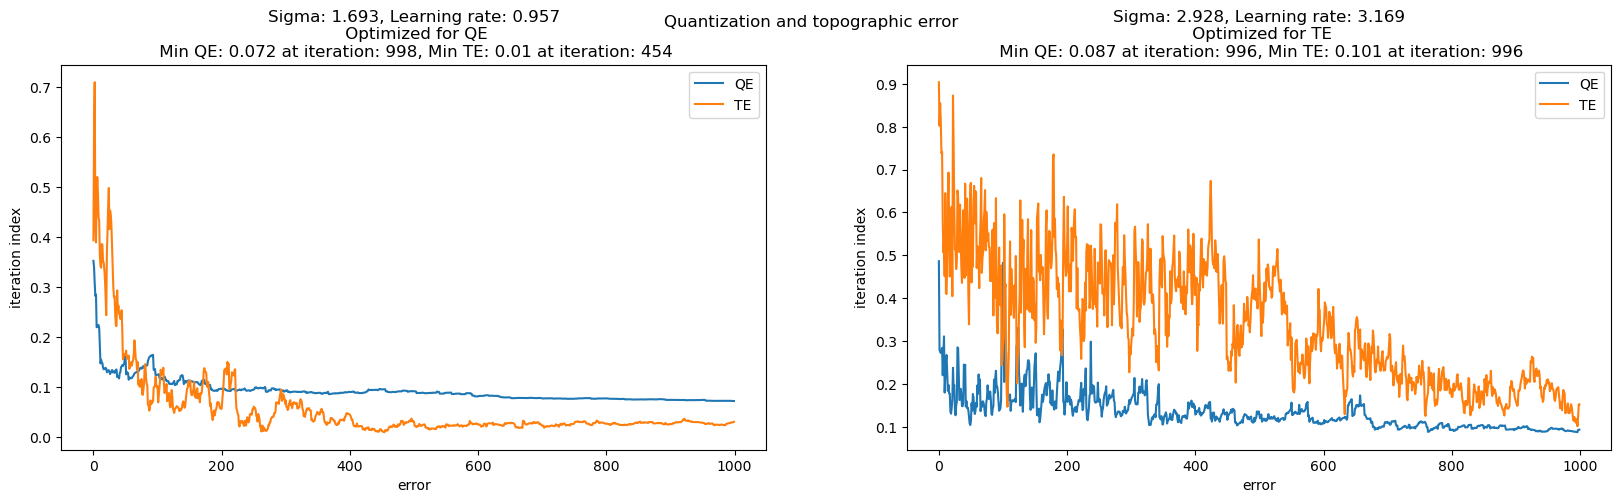

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
plt.suptitle("Quantization and topographic error")
axes[0].plot(np.arange(len(q_error_QE)), q_error_QE, label='QE')
axes[0].plot(np.arange(len(t_error_QE)), t_error_QE, label='TE')
axes[0].set_title("Sigma: {}, Learning rate: {}\n Optimized for QE\n Min QE: {} at iteration: {}, Min TE: {} at iteration: {}".format(np.round(sigma_QE, 3), np.round(learning_rate_QE, 3), np.round(np.min(q_error_QE), 3), np.argmin(q_error_QE), np.round(np.min(t_error_QE), 3), np.argmin(t_error_QE)))
axes[0].set_xlabel("error")
axes[0].set_ylabel("iteration index")
axes[0].legend()
axes[1].plot(np.arange(len(q_error_TE)), q_error_TE, label='QE')
axes[1].plot(np.arange(len(t_error_TE)), t_error_TE, label='TE')
axes[1].set_title("Sigma: {}, Learning rate: {}\n Optimized for TE\n Min QE: {} at iteration: {}, Min TE: {} at iteration: {}".format(np.round(sigma_TE, 3), np.round(learning_rate_TE, 3), np.round(np.min(q_error_TE), 3), np.argmin(q_error_TE), np.round(np.min(t_error_TE), 3), np.argmin(t_error_TE)))
axes[1].set_xlabel("error")
axes[1].set_ylabel("iteration index")
axes[1].legend()
plt.show()

In [24]:
                #40k is the number of neurons in the SOM (NOT the raccomended number of neurons)
som = train_som(dim_number, dim_number, features, sigma_QE, learning_rate_QE, 700)
som.quantization_error(X)

0.01409912109375 seconds


0.09133303660125666

# Visualization of data samples and categories

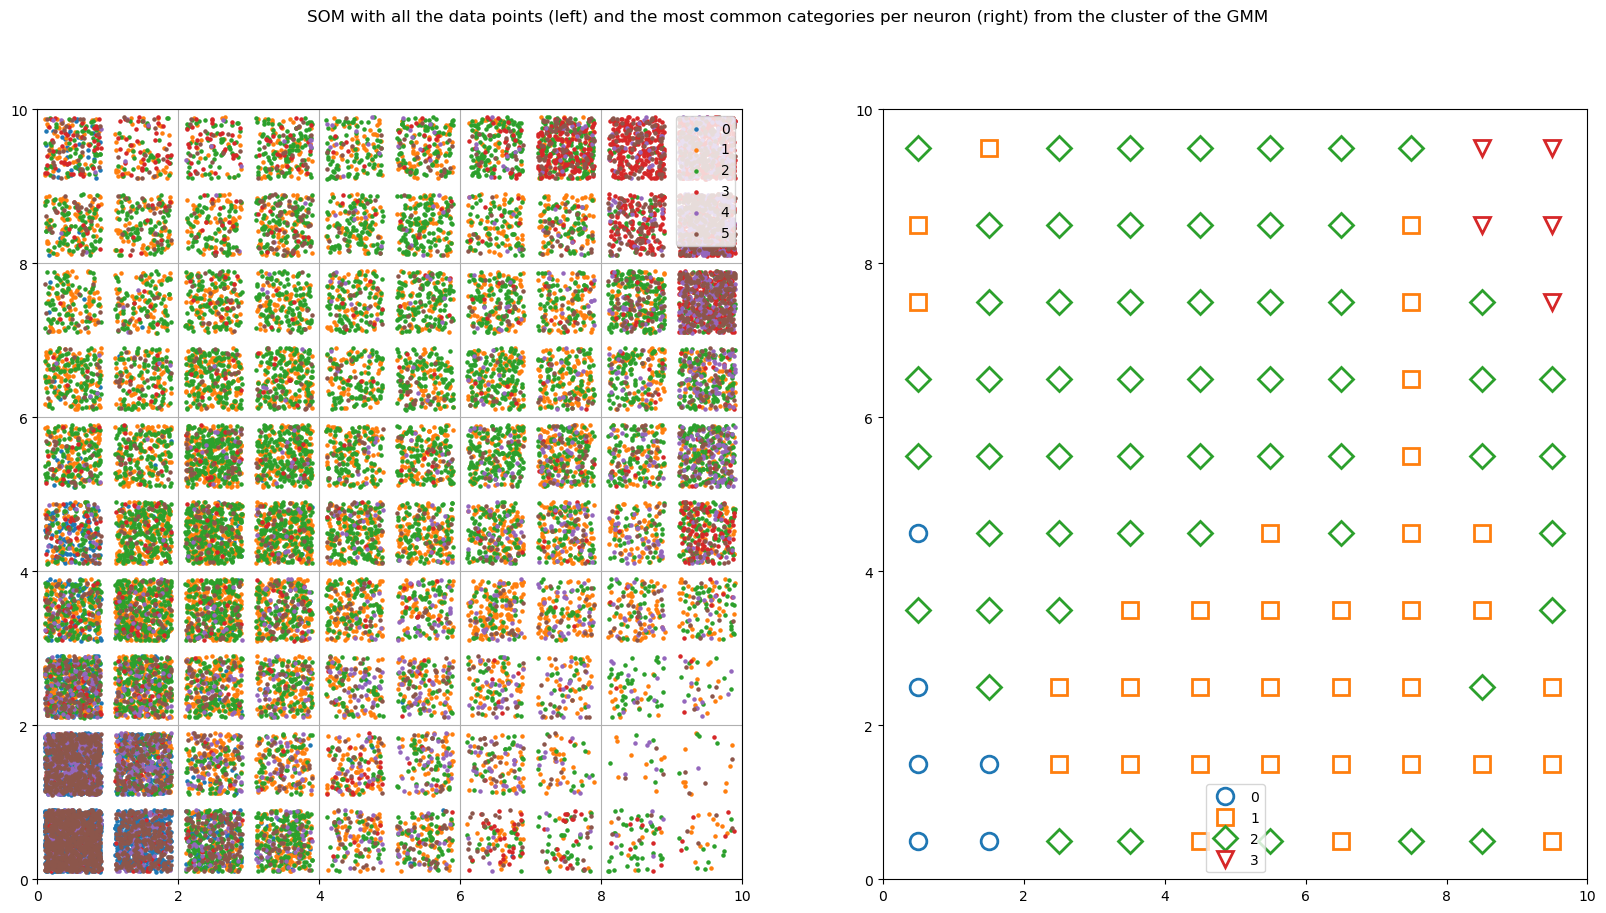

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plot_som(som, axes[0], data="sample")
category_map = project_feature(som, X, GMM_cluster_labels)
plot_feature(category_map, axes[1] ,scaling='category')
plt.suptitle("SOM with all the data points (left) and the most common categories per neuron (right) from the cluster of the GMM")
plt.show()


# Count visualization
The two plots show the distribution of the data points in the SOM, both in terms of the sum of the values of the features and the frequency of the winning neuron for each sample  
The difference is that the first plot use ad-hoc function written in this notebook, while the second plot use the som.activation_response function

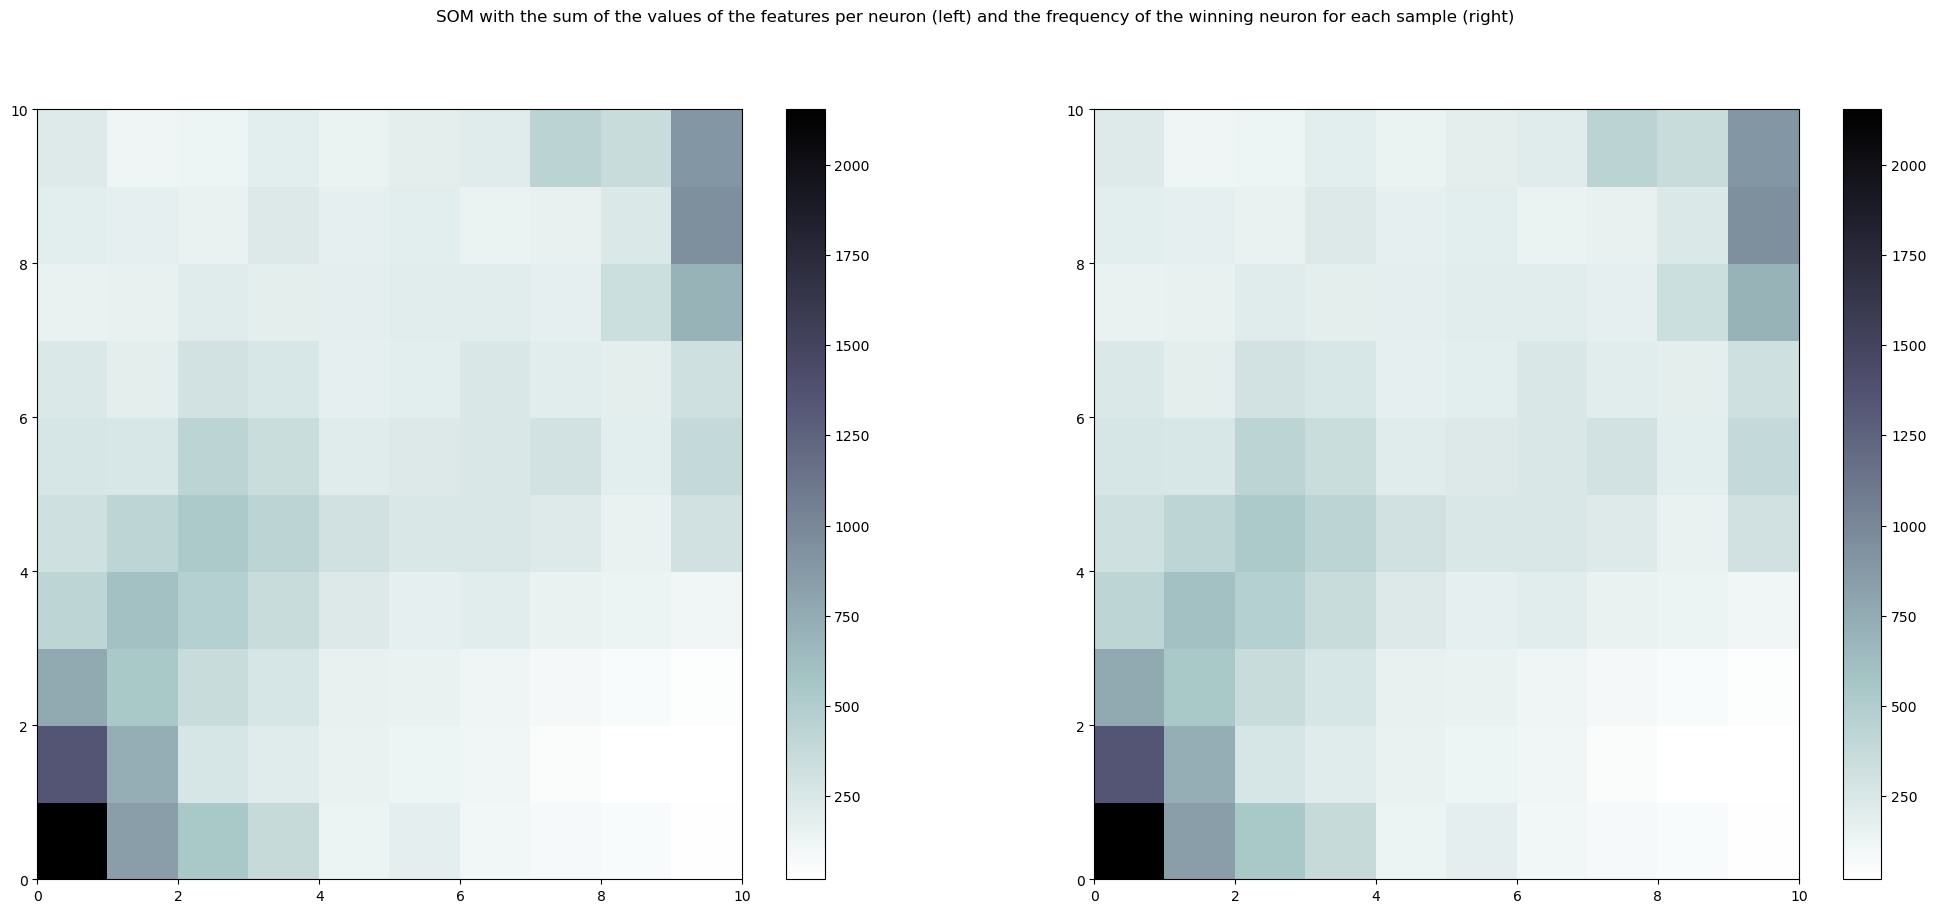

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
counts_map = project_feature(som, X, np.ones(len(X)))
plot_feature(counts_map, axes[0], fig, scaling='sum')
# plot the winning neuron for each sample using som.activation_response
frequencies = som.activation_response(X)
dmap = axes[1].pcolor(frequencies.T, cmap='bone_r')
fig.colorbar(dmap)
plt.suptitle("SOM with the sum of the values of the features per neuron (left) and the frequency of the winning neuron for each sample (right)")
plt.show()


# Plot of the distance map

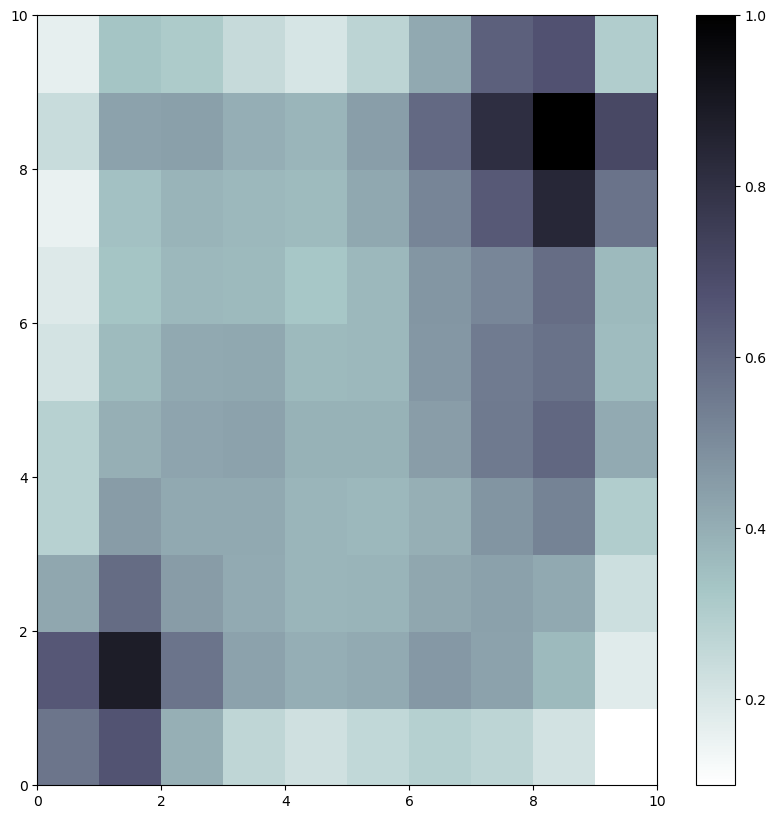

In [27]:
plot_distance_map(som)

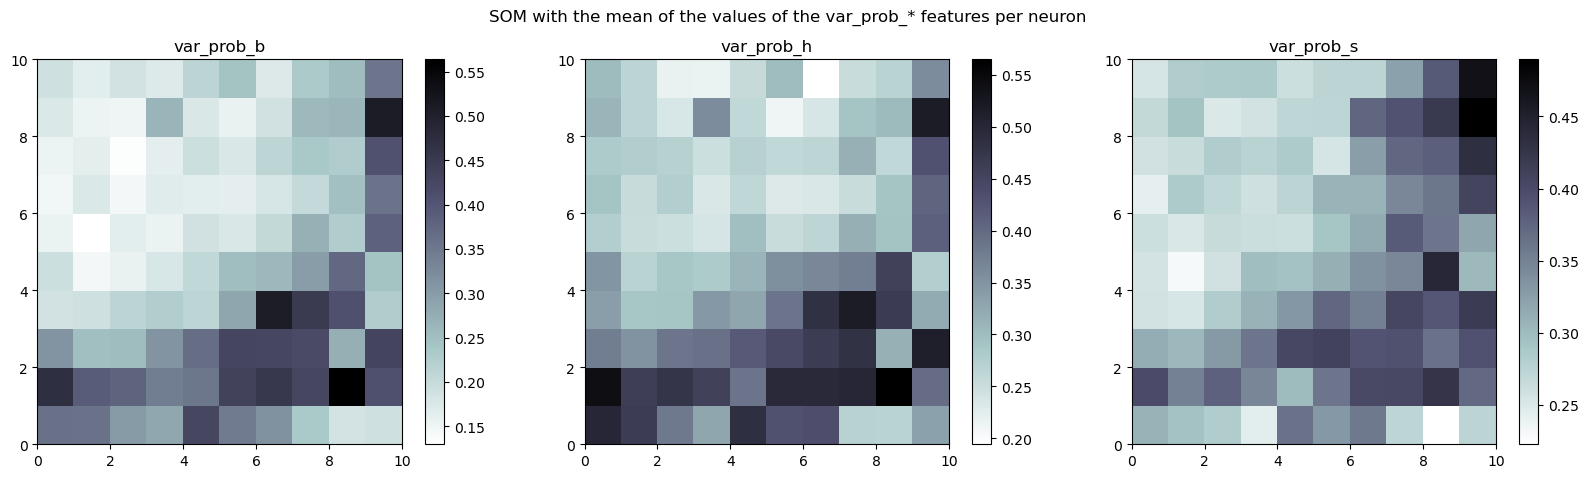

In [28]:
#'var_prob_b', 'var_prob_h', 'var_prob_s'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

var_prob_b_map = project_feature(som, X, raw_df['var_prob_b'])
plot_feature(var_prob_b_map, axes[0], fig, scaling='mean')
axes[0].set_title("var_prob_b")

var_prob_h_map = project_feature(som, X, raw_df['var_prob_h'])
plot_feature(var_prob_h_map, axes[1], fig, scaling='mean')
axes[1].set_title("var_prob_h")

var_prob_s_map = project_feature(som, X, raw_df['var_prob_s'])
plot_feature(var_prob_s_map, axes[2], fig, scaling='mean')
axes[2].set_title("var_prob_s")


plt.suptitle("SOM with the mean of the values of the var_prob_* features per neuron")
plt.show()

In [29]:
print(raw_df.columns)

Index(['col1', 'name', 'obsid', 'region_id', 'theta', 'ra', 'dec',
       'significance', 'likelihood', 'src_area_b', 'flux_aper_b', 'hard_hm',
       'hard_hs', 'hard_ms', 'powlaw_gamma', 'powlaw_gamma_lolim',
       'powlaw_gamma_hilim', 'bb_kt', 'bb_kt_lolim', 'bb_kt_hilim',
       'var_prob_b', 'var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b',
       'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h',
       'var_prob_m', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m',
       'var_prob_s', 'var_sigma_s', 'var_mean_s', 'var_min_s', 'var_max_s',
       'ks_prob_b', 'ks_prob_h', 'ks_prob_m', 'ks_prob_s', 'kp_prob_b',
       'kp_prob_h', 'kp_prob_m', 'kp_prob_s', 'gti_start', 'gti_stop',
       'gti_elapse', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b',
       'cluster', 'main_id', 'ra_simbad', 'dec_simbad', 'coo_err_maj',
       'coo_err_min', 'coo_err_angle', 'nbref', 'ra_sexa', 'dec_sexa',
       'coo_qual', 'coo_bibcode', 'main_type', 'othe